In [2]:
import cv2
import torch
import os
import random
import math
import glob 
import pathlib
import csv, PIL
import time, zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from PIL import Image
from os import listdir
from torchvision import*

%matplotlib inline

## k-fold validation

In [3]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os 
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
from platform import python_version

In [442]:
df = pd.read_csv('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/train_test_val.csv')
df.head()

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0


In [443]:
Kfold = GroupKFold(n_splits = 5)
df['fold'] = -1
df

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,fold
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,-1
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,-1
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,-1
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,-1
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,-1
...,...,...,...,...,...,...,...
2169,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0,-1
2170,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0,-1
2171,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0,-1
2172,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,-1


In [444]:
Kfold  = GroupKFold(n_splits = 5)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(Kfold.split(df, groups = df.converted_filename.values.tolist())):
    df.loc[val_idx, 'fold'] = fold
df.head()

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,fold
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,1
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,3
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,3
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,2
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,0


In [ ]:
df.groupby('fold')['converted_filename'].agg(lambda x : x.nunique()).reset_index()

In [15]:
df.fold.value_counts()

1    1451
0    1451
3    1450
2    1450
4    1450
Name: fold, dtype: int64

## Run model w/o duplication

https://jonsyou.tistory.com/23

https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

In [58]:
classLabels

['Effusion', 'Consolidations', 'B-lines', 'Healthy']

In [70]:
new = df.sort_values('Effusion', ascending=False).drop_duplicates(subset=['Effusion', 'Consolidations', 'B-lines', 'Healthy'])
new

,converted_filename,Effusion,Consolidations,B-lines,Healthy
659,Cov-grepmed-blines-pocus-_frame_162.jpg,1,0,1,0
3272,Cov_denault_proposedUS_vid11_frame_012.jpg,1,1,0,0
745,Cov_denault_proposedUS_vid10_frame_105.jpg,1,1,1,0
6580,Pneu_northumbria_0409_set1_vid2_frame_027.jpg,1,0,0,0
4772,Reg_pat1Image_133138_frame_159.jpg,0,0,0,1
4769,Pneu_AIR BRONC2_frame_033.jpg,0,1,0,0
5277,Cov_convex_volpecelli_sonographic_v3_frame_351...,0,0,1,0
4895,Cov-grep-7453_frame_237.jpg,0,1,1,1
5276,Cov_new_pregnant_vid4_frame_084.jpg,0,1,1,0
4771,Reg-Youtube_frame_081.jpg,0,0,1,1


In [74]:
new = df.sort_values('Effusion').drop_duplicates(['Effusion', 'Consolidations', 'B-lines', 'Healthy'] ,keep= 'last')
new

,converted_filename,Effusion,Consolidations,B-lines,Healthy
2311,Cov-Atlas-Day+1_frame_003.jpg,0,1,0,1
2460,Cov-grep-7453_frame_150.jpg,0,1,1,1
2387,Cov_combatting_Image3_frame_072.jpg,0,1,1,0
1975,Reg-Youtube_frame_144.jpg,0,0,1,1
2379,Vir_prospective_file2_frame_111.jpg,0,0,1,0
2358,Pneu_AIR BRONC2_frame_027.jpg,0,1,0,0
2361,Reg_pat3Image_134904_frame_114.jpg,0,0,0,1
2226,Pneu_northumbria_0409_set3_vid1_frame_084.jpg,1,0,0,0
3993,Pneu_clinicalreview_MOV4_frame_024.jpg,1,1,1,0
6489,Cov_denault_proposedUS_vid12_frame_018.jpg,1,1,0,0


In [140]:
img_name = df['converted_filename']
img_name

0       Cov_combatting_Image1_frame_003.jpg
1       Cov_combatting_Image1_frame_006.jpg
2       Cov_combatting_Image1_frame_009.jpg
3       Cov_combatting_Image1_frame_012.jpg
4       Cov_combatting_Image1_frame_015.jpg
                       ...                 
7247          Reg-Grep-Normal_frame_021.jpg
7248          Reg-Grep-Normal_frame_024.jpg
7249          Reg-Grep-Normal_frame_027.jpg
7250          Reg-Grep-Normal_frame_030.jpg
7251          Reg-Grep-Normal_frame_033.jpg
Name: converted_filename, Length: 7252, dtype: object

In [143]:
file_name = []

for i in range(len(img_name)):
    file_name.append(img_name[i].split('_frame_')[0])

print('The number of the files are : {},\nThe first file is : {}, \nThe last file is : {}'.format(len(file_name),file_name[0], file_name[-1] ))

The number of the files are : 7252,
The first file is : Cov_combatting_Image1, 
The last file is : Reg-Grep-Normal


In [144]:
csv_list = pd.DataFrame({'Filename' : file_name, 
                         'converted_filename' : df['converted_filename'], 
                         'Effusion' : df['Effusion'], 
                         'Consolidations' : df['Consolidations'], 
                         'B-lines' : df['B-lines'], 'Healthy' : df['Healthy']})
csv_list

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov_combatting_Image1,Cov_combatting_Image1_frame_003.jpg,0,0,1,1
1,Cov_combatting_Image1,Cov_combatting_Image1_frame_006.jpg,0,0,1,1
2,Cov_combatting_Image1,Cov_combatting_Image1_frame_009.jpg,0,0,1,1
3,Cov_combatting_Image1,Cov_combatting_Image1_frame_012.jpg,0,0,1,1
4,Cov_combatting_Image1,Cov_combatting_Image1_frame_015.jpg,0,0,1,1
...,...,...,...,...,...,...
7247,Reg-Grep-Normal,Reg-Grep-Normal_frame_021.jpg,0,0,0,1
7248,Reg-Grep-Normal,Reg-Grep-Normal_frame_024.jpg,0,0,0,1
7249,Reg-Grep-Normal,Reg-Grep-Normal_frame_027.jpg,0,0,0,1
7250,Reg-Grep-Normal,Reg-Grep-Normal_frame_030.jpg,0,0,0,1


In [194]:
new = csv_list.groupby('Filename').tail(70)
new = new.groupby('Filename').head(4)

new

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov_combatting_Image1,Cov_combatting_Image1_frame_003.jpg,0,0,1,1
1,Cov_combatting_Image1,Cov_combatting_Image1_frame_006.jpg,0,0,1,1
2,Cov_combatting_Image1,Cov_combatting_Image1_frame_009.jpg,0,0,1,1
3,Cov_combatting_Image1,Cov_combatting_Image1_frame_012.jpg,0,0,1,1
37,Cov_combatting_Image2,Cov_combatting_Image2_frame_003.jpg,0,0,1,0
...,...,...,...,...,...,...
7224,Reg-Atlas-lungcurtain,Reg-Atlas-lungcurtain_frame_012.jpg,0,0,0,1
7241,Reg-Grep-Normal,Reg-Grep-Normal_frame_003.jpg,0,0,0,1
7242,Reg-Grep-Normal,Reg-Grep-Normal_frame_006.jpg,0,0,0,1
7243,Reg-Grep-Normal,Reg-Grep-Normal_frame_009.jpg,0,0,0,1


In [211]:
df = csv_list.groupby('Filename').sample(frac=0.3).reset_index(drop=True)
df

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0
...,...,...,...,...,...,...
2169,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0
2170,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0
2171,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0
2172,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0


Pneu_northumbria_0409_set2_vid2_frame_063.jpg


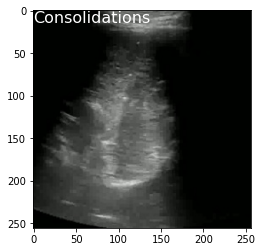

In [234]:
classLabels = ["Effusion", "Consolidations", "B-lines", "Healthy"]
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd.converted_filename
    label = fd[2:].tolist()
    print(image)
    try:
        image = Image.open("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"+image)
    except:
        pass 
    
    fig,ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes =  np.array(classLabels)[np.array(label,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16)
    plt.show()
    
visualizeImage(999)

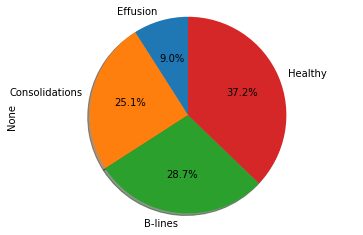

In [235]:
fig1, ax1 = plt.subplots()
df.iloc[:,2:].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

In [236]:
#Images in the dataset have different sizes to lets take a mean size while resizing 224*224
l= []

for i in df.converted_filename:
    with Image.open(Path("/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/")/i) as f:
        l.append(f.size)
        
np.array(l).mean(axis=0),np.median(np.array(l) , axis=0)

(array([256., 256.]), array([256., 256.]))

In [237]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"'{device}' is avilable.")

'cuda' is avilable.


In [238]:
img_path = "/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"

In [239]:
from skimage import io

class USDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 2:].astype(int))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

https://stackoverflow.com/questions/67016628/how-to-split-duplicate-samples-to-train-test-with-no-overlapping

https://stats.stackexchange.com/questions/468458/data-leakage-in-temporally-overlapping-train-test-split

In [240]:
dataset = USDataset(
    csv_file="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/final_csv2.csv",
    root_dir="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/",
    transform=transformations,
)

In [244]:
img_path

'/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/'

In [243]:
df

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0
...,...,...,...,...,...,...
2169,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0
2170,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0
2171,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0
2172,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0


In [245]:
df['file_path'] = f'/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/' + df.converted_filename
df.head()

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,file_path
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...


## into the newfolders


In [246]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

image_files = df['file_path']

images = [name.replace("jpg", "") for name in image_files]

#splitting the dataset 8:1:1
train_names, test_names = train_test_split(images, test_size = 0.2, random_state = 42, shuffle = True)
val_names, test_names = train_test_split(images, test_size = 0.5, random_state = 42, shuffle = True)

In [250]:
print(len(train_names), len(test_names), len(val_names))

1739 1087 1087


In [257]:
def batch_move_files(file_list, source_path, destination_path):
    for file in file_list:
        # 경로에서 마지막 파일명만 가져와서 확장자 붙여줌 #참고 : https://lynnshin.tistory.com/46
        image = file.split('/')[-1] + 'jpg'
        #text = file.split('/')+ '.json'
        shutil.copy(os.path.join(source_path, image), destination_path)
        #shutil.copy(os.path.join(source_path, txt), destination_path)
    return

In [258]:
source_dir = img_path
test_dir = '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test'
train_dir = '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/train'
val_dir = '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/val'

In [300]:
batch_move_files(train_names, source_dir, train_dir)
batch_move_files(test_names, source_dir, test_dir)
batch_move_files(val_names, source_dir, val_dir)

In [301]:
len(train_names), len(test_names), len(val_names)

(1739, 1087, 1087)

## Path와 이름 구별하기

In [264]:
temp = glob.glob('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/'+'*/*.jpg')
temp[:4]

['/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test/Cov_combatting_image4_frame_036.jpg',
 '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test/Vir_whitelung_h1n1_frame_114.jpg',
 '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test/Cov_denault_proposedUS_vid14_frame_045.jpg',
 '/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test/Reg-NormalLungs_frame_087.jpg']

In [265]:
temp[0].split('/00_pocovid_img/')[-1]

'test/Cov_combatting_image4_frame_036.jpg'

In [269]:
train_names[1]

'/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/Vir_whitelung_h1n1_frame_114.'

In [278]:
file_name = []
file_type = []

for i in range(len(train_names)):
    file_type.append(train_names[i].split('/')[-1].split('.')[0]+'.jpg')#.split('.')[0])
    file_name.append(train_names[i].split('/')[-1].split('.')[0].split('_frame')[0])
    #file_name.sort()

print('The number of the files are : {},\nThe first file is : {}, \nThe last file is : {}'.format(len(file_type),file_type[0], file_type[-1] ))
print('The number of the files are : {},\nThe first file is : {}, \nThe last file is : {}'.format(len(file_name),file_name[0], file_name[-1] ))

The number of the files are : 1739,
The first file is : Cov_combatting_image4_frame_036.jpg, 
The last file is : Pneu-grep-pneumonia3_frame_006.jpg
The number of the files are : 1739,
The first file is : Cov_combatting_image4, 
The last file is : Pneu-grep-pneumonia3


In [281]:
import pandas as pd
csv_list = pd.DataFrame({'converted_filename' : file_type,
                         'Filename' : file_name})
csv_list

,converted_filename,Filename
0,Cov_combatting_image4_frame_036.jpg,Cov_combatting_image4
1,Vir_whitelung_h1n1_frame_114.jpg,Vir_whitelung_h1n1
2,Cov_denault_proposedUS_vid14_frame_045.jpg,Cov_denault_proposedUS_vid14
3,Reg-NormalLungs_frame_087.jpg,Reg-NormalLungs
4,Reg_pat4Image_140606_frame_156.jpg,Reg_pat4Image_140606
...,...,...
1734,Reg_pat2Image_133952_frame_075.jpg,Reg_pat2Image_133952
1735,Pneu_northumbria_0409_set6_vid5_frame_015.jpg,Pneu_northumbria_0409_set6_vid5
1736,Pneu_prospective_file3_frame_120.jpg,Pneu_prospective_file3
1737,Reg_Avi_Image008_frame_165.jpg,Reg_Avi_Image008


In [286]:
result = pd.merge(df,
                 csv_list[['converted_filename']], #, 'Filename', 'Effusion','Consolidations','B-lines','Healthy']],
                 on='converted_filename')
result

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,file_path
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
...,...,...,...,...,...,...,...
1734,pneu-radiopaeda,pneu-radiopaeda_frame_027.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1735,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1736,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1737,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...


### Train 확인


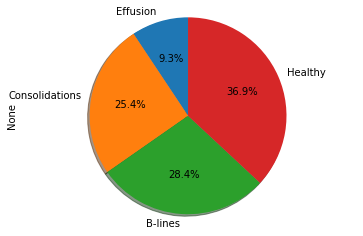

In [346]:
file_name = []
file_type = []

for i in range(len(train_names)):
    file_type.append(train_names[i].split('/')[-1].split('.')[0]+'.jpg')#.split('.')[0])
    file_name.append(train_names[i].split('/')[-1].split('.')[0].split('_frame')[0])
    #file_name.sort()


csv_list = pd.DataFrame({'converted_filename' : file_type,
                         'Filename' : file_name})


result = pd.merge(df,
                 csv_list[['converted_filename']], #, 'Filename', 'Effusion','Consolidations','B-lines','Healthy']],
                 on='converted_filename')

    
    
fig1, ax1 = plt.subplots()
result.iloc[:,2:6].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

### test split 확인


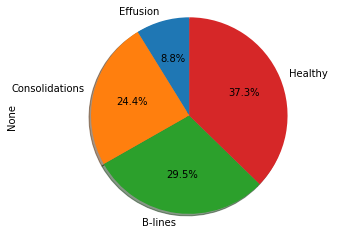

In [303]:
file_name = []
file_type = []

for i in range(len(test_names)):
    file_type.append(test_names[i].split('/')[-1].split('.')[0]+'.jpg')#.split('.')[0])
    file_name.append(test_names[i].split('/')[-1].split('.')[0].split('_frame')[0])
    #file_name.sort()

csv_list = pd.DataFrame({'converted_filename' : file_type,
                         'Filename' : file_name})


result = pd.merge(df,
                 csv_list[['converted_filename']], #, 'Filename', 'Effusion','Consolidations','B-lines','Healthy']],
                 on='converted_filename')

fig1, ax1 = plt.subplots()
result.iloc[:,2:6].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

### Valid 확인

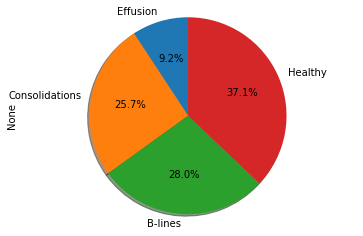

In [304]:
file_name = []
file_type = []

for i in range(len(val_names)):
    file_type.append(val_names[i].split('/')[-1].split('.')[0]+'.jpg')#.split('.')[0])
    file_name.append(val_names[i].split('/')[-1].split('.')[0].split('_frame')[0])
    #file_name.sort()

csv_list = pd.DataFrame({'converted_filename' : file_type,
                         'Filename' : file_name})


result = pd.merge(df,
                 csv_list[['converted_filename']], #, 'Filename', 'Effusion','Consolidations','B-lines','Healthy']],
                 on='converted_filename')

fig1, ax1 = plt.subplots()
result.iloc[:,2:6].sum(axis=0).plot.pie(autopct='%1.1f%%',shadow=True, startangle=90,ax=ax1)
ax1.axis("equal")
plt.show()

## csv만들기

In [356]:
temp = glob.glob('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/'+'*/*.jpg')
len(temp)

3913

In [357]:
temp[0]

'/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/test/Cov_convex_volpecelli_sonographic_v1_frame_282.jpg'

In [358]:
temp[0].split('/00_pocovid_img/')[-1].split('/')[-1]

'Cov_convex_volpecelli_sonographic_v1_frame_282.jpg'

In [394]:
file_name = []
file_type = []

for i in range(len(temp)):
    file_type.append(temp[i].split('/00_pocovid_img/')[-1])#.split('.')[0])
    file_name.append(temp[i].split('/00_pocovid_img/')[-1].split('/')[-1])
    #file_name.sort()

print('The number of the files are : {},\nThe first file is : {}, \nThe last file is : {}'.format(len(file_type),file_type[0], file_type[-1] ))
print('The number of the files are : {},\nThe first file is : {}, \nThe last file is : {}'.format(len(file_name),file_name[0], file_name[-1] ))

The number of the files are : 3913,
The first file is : test/Cov_convex_volpecelli_sonographic_v1_frame_282.jpg, 
The last file is : val/Pneu-grep-pneumonia3_frame_006.jpg
The number of the files are : 3913,
The first file is : Cov_convex_volpecelli_sonographic_v1_frame_282.jpg, 
The last file is : Pneu-grep-pneumonia3_frame_006.jpg


In [397]:
new_list = pd.DataFrame({'new_names' : file_type,
                         'converted_filename' : file_name})
new_list

,new_names,converted_filename
0,test/Cov_convex_volpecelli_sonographic_v1_fram...,Cov_convex_volpecelli_sonographic_v1_frame_282...
1,test/Reg_pat1Image_133043_frame_132.jpg,Reg_pat1Image_133043_frame_132.jpg
2,test/Pneu-grep-bacterial-hepatization-clinical...,Pneu-grep-bacterial-hepatization-clinical_fram...
3,test/Cov_new_pregnant_vid8_frame_123.jpg,Cov_new_pregnant_vid8_frame_123.jpg
4,test/Reg-Youtube_frame_117.jpg,Reg-Youtube_frame_117.jpg
...,...,...
3908,val/Reg_pat2Image_133952_frame_075.jpg,Reg_pat2Image_133952_frame_075.jpg
3909,val/Pneu_northumbria_0409_set6_vid5_frame_015.jpg,Pneu_northumbria_0409_set6_vid5_frame_015.jpg
3910,val/Pneu_prospective_file3_frame_120.jpg,Pneu_prospective_file3_frame_120.jpg
3911,val/Reg_Avi_Image008_frame_165.jpg,Reg_Avi_Image008_frame_165.jpg


In [398]:
df

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,file_path
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
4,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
...,...,...,...,...,...,...,...
2169,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2170,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2171,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...
2172,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...


In [399]:
result = pd.merge(df,
                 new_list[['converted_filename', 'new_names']], #, 'Filename', 'Effusion','Consolidations','B-lines','Healthy']],
                 on='converted_filename')
result

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,file_path,new_names
0,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/Cov-Atlas+(44)_frame_012.jpg
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas+(44)_frame_012.jpg
2,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/Cov-Atlas+(44)_frame_009.jpg
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas+(44)_frame_009.jpg
4,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,test/Cov-Atlas+(44)_frame_039.jpg
...,...,...,...,...,...,...,...,...
3908,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,test/pneu-radiopaeda_frame_081.jpg
3909,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,test/pneu-radiopaeda_frame_018.jpg
3910,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/pneu-radiopaeda_frame_018.jpg
3911,pneu-radiopaeda,pneu-radiopaeda_frame_132.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/pneu-radiopaeda_frame_132.jpg


In [485]:
result = result.drop_duplicates(['converted_filename'], keep='last')
result

,Filename,converted_filename,Effusion,Consolidations,B-lines,Healthy,file_path,new_names
1,Cov-Atlas+(44),Cov-Atlas+(44)_frame_012.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas+(44)_frame_012.jpg
3,Cov-Atlas+(44),Cov-Atlas+(44)_frame_009.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas+(44)_frame_009.jpg
5,Cov-Atlas+(44),Cov-Atlas+(44)_frame_039.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/Cov-Atlas+(44)_frame_039.jpg
7,Cov-Atlas+(44),Cov-Atlas+(44)_frame_033.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas+(44)_frame_033.jpg
9,Cov-Atlas-+(43),Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/Cov-Atlas-+(43)_frame_012.jpg
...,...,...,...,...,...,...,...,...
3905,pneu-radiopaeda,pneu-radiopaeda_frame_096.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/pneu-radiopaeda_frame_096.jpg
3907,pneu-radiopaeda,pneu-radiopaeda_frame_036.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,val/pneu-radiopaeda_frame_036.jpg
3908,pneu-radiopaeda,pneu-radiopaeda_frame_081.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,test/pneu-radiopaeda_frame_081.jpg
3910,pneu-radiopaeda,pneu-radiopaeda_frame_018.jpg,0,1,0,0,/home/Sean/PoCOVID/4real/covid19_pocus_ultraso...,train/pneu-radiopaeda_frame_018.jpg


In [486]:
df_new = result[[ 'new_names', 'converted_filename', 'Effusion', 'Consolidations', 'B-lines' , 'Healthy']]
df_new

,new_names,converted_filename,Effusion,Consolidations,B-lines,Healthy
1,val/Cov-Atlas+(44)_frame_012.jpg,Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
3,val/Cov-Atlas+(44)_frame_009.jpg,Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
5,train/Cov-Atlas+(44)_frame_039.jpg,Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
7,val/Cov-Atlas+(44)_frame_033.jpg,Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
9,val/Cov-Atlas-+(43)_frame_012.jpg,Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0
...,...,...,...,...,...,...
3905,val/pneu-radiopaeda_frame_096.jpg,pneu-radiopaeda_frame_096.jpg,0,1,0,0
3907,val/pneu-radiopaeda_frame_036.jpg,pneu-radiopaeda_frame_036.jpg,0,1,0,0
3908,test/pneu-radiopaeda_frame_081.jpg,pneu-radiopaeda_frame_081.jpg,0,1,0,0
3910,train/pneu-radiopaeda_frame_018.jpg,pneu-radiopaeda_frame_018.jpg,0,1,0,0


In [487]:
df_new = result[[ 'new_names', 'Effusion', 'Consolidations', 'B-lines' , 'Healthy']]
df_new

,new_names,Effusion,Consolidations,B-lines,Healthy
1,val/Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
3,val/Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
5,train/Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
7,val/Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
9,val/Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0
...,...,...,...,...,...
3905,val/pneu-radiopaeda_frame_096.jpg,0,1,0,0
3907,val/pneu-radiopaeda_frame_036.jpg,0,1,0,0
3908,test/pneu-radiopaeda_frame_081.jpg,0,1,0,0
3910,train/pneu-radiopaeda_frame_018.jpg,0,1,0,0


In [488]:
df_new.to_csv('train_test_val.csv', index=False)

In [489]:
df = pd.read_csv('/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/train_test_val.csv')
df

,new_names,Effusion,Consolidations,B-lines,Healthy
0,val/Cov-Atlas+(44)_frame_012.jpg,0,1,0,0
1,val/Cov-Atlas+(44)_frame_009.jpg,0,1,0,0
2,train/Cov-Atlas+(44)_frame_039.jpg,0,1,0,0
3,val/Cov-Atlas+(44)_frame_033.jpg,0,1,0,0
4,val/Cov-Atlas-+(43)_frame_012.jpg,0,0,1,0
...,...,...,...,...,...
2169,val/pneu-radiopaeda_frame_096.jpg,0,1,0,0
2170,val/pneu-radiopaeda_frame_036.jpg,0,1,0,0
2171,test/pneu-radiopaeda_frame_081.jpg,0,1,0,0
2172,train/pneu-radiopaeda_frame_018.jpg,0,1,0,0


## Loader

In [490]:
img_path = "/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/"
#img_path = "/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/vidtoimg/"

In [491]:
from skimage import io

class USDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 1:].astype(int))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [536]:
transformations = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), 
                                      transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [537]:
dataset = USDataset(
    csv_file="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/train_test_val.csv",
    root_dir="/home/Sean/PoCOVID/4real/covid19_pocus_ultrasound_pytorch/code/data/00_pocovid_img/",
    transform=transformations,
)

In [538]:
train_img= df['new_names'].iloc[:]
train_img

0          val/Cov-Atlas+(44)_frame_012.jpg
1          val/Cov-Atlas+(44)_frame_009.jpg
2        train/Cov-Atlas+(44)_frame_039.jpg
3          val/Cov-Atlas+(44)_frame_033.jpg
4         val/Cov-Atlas-+(43)_frame_012.jpg
                       ...                 
2169      val/pneu-radiopaeda_frame_096.jpg
2170      val/pneu-radiopaeda_frame_036.jpg
2171     test/pneu-radiopaeda_frame_081.jpg
2172    train/pneu-radiopaeda_frame_018.jpg
2173      val/pneu-radiopaeda_frame_132.jpg
Name: new_names, Length: 2174, dtype: object

In [539]:
n_train = (round(len(train_img)*0.8))
n_val = round(len(train_img)*0.1)
n_test = round(len(train_img)*0.1)
print(f"Total Number of the images : {len(train_img)} \nThe proportion of the [8:1:1] : {round(len(train_img)*0.8)}, {round(len(train_img)*0.1)}, {round(len(train_img)*0.1)}")

Total Number of the images : 2174 
The proportion of the [8:1:1] : 1739, 217, 217


In [540]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train+1, n_val, n_test])
random_seed = 0
torch.manual_seed(random_seed)
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True) 
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True) 
test_loader = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True) 

print(f'Train : {len(train_ds)}, Validation : {len(val_ds)}, Test : {len(test_ds)}')

Train : 1740, Validation : 217, Test : 217


In [688]:
dataloader = {"train":DataLoader(train_ds , shuffle=True , batch_size=batch_size),
              "val": DataLoader(val_ds , shuffle=True , batch_size=batch_size),
              "test": DataLoader(test_ds , shuffle=True , batch_size=batch_size) }

In [738]:
# Hyperparameters
in_channel = 3
num_classes = 4
learning_rate = 1e-5
batch_size = 64
num_epochs = 10

In [747]:
model = torchvision.models.resnet50(pretrained=True)

In [748]:
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
    param.requires_grad_(False)

2048


In [749]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
        layers.append(nn.Linear(in_f , out_f))
        layers.append(activation_func())
        layers.append(nn.BatchNorm1d(out_f))
        if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) # because ten classes
model.fc = top_head # replace the fully connected layer


In [750]:
import torch.optim as optim
model.to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [696]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer , num_epochs=5):
    for epoch in trange(num_epochs,desc="Epochs"):
        result = []
        for phase in ['train', 'val']:
            if phase=="train":     # put the model in training mode
                model.train()
                #scheduler.step()
            else:     # put the model in validation mode
                model.eval()
       
            # keep track of training and validation loss
            running_loss = 0.0
            running_corrects = 0.0  
            
            for data , target in data_loader[phase]:
                #load the data and target to respective device
                data , target = data.to(device)  , target.to(device)
                
                with torch.set_grad_enabled(phase=="train"):
                    #feed the input
                    output = model(data)
                    #calculate the loss
                    loss = criterion(output,target.float())
                    preds = torch.sigmoid(output).data > 0.5
                    preds = preds.to(torch.float32)
                    
                    if phase=="train"  :
                        # backward pass: compute gradient of the loss with respect to model parameters 
                        loss.backward()
                        # update the model parameters
                        optimizer.step()
                        # zero the grad to stop it from accumulating
                        optimizer.zero_grad()
                        
                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects / len(data_loader[phase].dataset)
            
            result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print(result)

In [637]:
train(model,dataloader , criterion, optimizer, num_epochs=num_epochs)

Epochs:  10%|█         | 1/10 [00:10<01:36, 10.72s/it]

['train Loss: 0.7021 Acc: 0.4311', 'val Loss: 0.6932 Acc: 0.4802']


Epochs:  20%|██        | 2/10 [00:21<01:24, 10.62s/it]

['train Loss: 0.6274 Acc: 0.5343', 'val Loss: 0.5756 Acc: 0.6243']


Epochs:  30%|███       | 3/10 [00:31<01:14, 10.60s/it]

['train Loss: 0.5800 Acc: 0.6005', 'val Loss: 0.5287 Acc: 0.6806']


Epochs:  40%|████      | 4/10 [00:42<01:04, 10.73s/it]

['train Loss: 0.5380 Acc: 0.6500', 'val Loss: 0.5013 Acc: 0.7124']


Epochs:  50%|█████     | 5/10 [00:53<00:53, 10.67s/it]

['train Loss: 0.5157 Acc: 0.6768', 'val Loss: 0.4787 Acc: 0.7266']


Epochs:  60%|██████    | 6/10 [01:03<00:42, 10.59s/it]

['train Loss: 0.4973 Acc: 0.6867', 'val Loss: 0.4610 Acc: 0.7439']


Epochs:  70%|███████   | 7/10 [01:14<00:31, 10.64s/it]

['train Loss: 0.4693 Acc: 0.7239', 'val Loss: 0.4364 Acc: 0.7697']


Epochs:  80%|████████  | 8/10 [01:25<00:21, 10.65s/it]

['train Loss: 0.4595 Acc: 0.7201', 'val Loss: 0.4316 Acc: 0.7806']


Epochs:  90%|█████████ | 9/10 [01:36<00:10, 10.84s/it]

['train Loss: 0.4459 Acc: 0.7345', 'val Loss: 0.4238 Acc: 0.7783']


Epochs: 100%|██████████| 10/10 [01:46<00:00, 10.69s/it]

['train Loss: 0.4307 Acc: 0.7447', 'val Loss: 0.4088 Acc: 0.7955']


In [742]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.003 )

In [751]:
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):
    for epoch in trange(num_epochs,desc="Epochs"):
        result = []
        for phase in ['train', 'val']:
            if phase=="train":     # put the model in training mode
                model.train()
                scheduler.step()
            else:     # put the model in validation mode
                model.eval()
       
            # keep track of training and validation loss
            running_loss = 0.0
            running_corrects = 0.0  
            
            for data , target in data_loader[phase]:
                #load the data and target to respective device
                data , target = data.to(device)  , target.to(device)
                
                with torch.set_grad_enabled(phase=="train"):
                    #feed the input
                    output = model(data)
                    #calculate the loss
                    loss = criterion(output,target.float())
                    preds = torch.sigmoid(output).data > 0.5
                    preds = preds.to(torch.float32)
                    
                    if phase=="train"  :
                        # backward pass: compute gradient of the loss with respect to model parameters 
                        loss.backward()
                        # update the model parameters
                        optimizer.step()
                        # zero the grad to stop it from accumulating
                        optimizer.zero_grad()
                        
                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
                
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = running_corrects / len(data_loader[phase].dataset)
            
            result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print(result)

In [752]:
train(model,dataloader , criterion, optimizer,sgdr_partial,num_epochs=num_epochs)

Epochs:  10%|█         | 1/10 [00:12<01:54, 12.77s/it]

['train Loss: 0.7246 Acc: 0.3970', 'val Loss: 0.6601 Acc: 0.4876']


Epochs:  20%|██        | 2/10 [00:24<01:38, 12.36s/it]

['train Loss: 0.6457 Acc: 0.5236', 'val Loss: 0.5632 Acc: 0.6899']


Epochs:  30%|███       | 3/10 [00:35<01:24, 12.05s/it]

['train Loss: 0.5958 Acc: 0.5919', 'val Loss: 0.5187 Acc: 0.7101']


Epochs:  40%|████      | 4/10 [00:47<01:11, 11.91s/it]

['train Loss: 0.5565 Acc: 0.6238', 'val Loss: 0.4946 Acc: 0.7265']


Epochs:  50%|█████     | 5/10 [00:58<00:58, 11.75s/it]

['train Loss: 0.5360 Acc: 0.6504', 'val Loss: 0.4726 Acc: 0.7611']


Epochs:  60%|██████    | 6/10 [01:09<00:46, 11.62s/it]

['train Loss: 0.5103 Acc: 0.6742', 'val Loss: 0.4605 Acc: 0.7695']


Epochs:  70%|███████   | 7/10 [01:20<00:34, 11.45s/it]

['train Loss: 0.4985 Acc: 0.6869', 'val Loss: 0.4440 Acc: 0.7907']


Epochs:  80%|████████  | 8/10 [01:31<00:22, 11.28s/it]

['train Loss: 0.4748 Acc: 0.7070', 'val Loss: 0.4300 Acc: 0.8038']


Epochs:  90%|█████████ | 9/10 [01:42<00:11, 11.26s/it]

['train Loss: 0.4608 Acc: 0.7259', 'val Loss: 0.4198 Acc: 0.7990']


Epochs: 100%|██████████| 10/10 [01:54<00:00, 11.43s/it]

['train Loss: 0.4515 Acc: 0.7196', 'val Loss: 0.4136 Acc: 0.8059']


In [753]:
class LinearScheduler(lr_scheduler._LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of iterations."""
    def __init__(self, optimizer, end_lr, num_iter):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearScheduler,self).__init__(optimizer)

    def get_lr(self):
        # increement one by one
        curr_iter = self.last_epoch + 1
        # get the ratio
        pct = curr_iter / self.num_iter
        # calculate lr with this formulae start + pct * (end-start)
        return [base_lr + pct * (self.end_lr - base_lr) for base_lr in self.base_lrs]
    
class ExponentialScheduler(lr_scheduler._LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** pct for base_lr in self.base_lrs]
    
class CosineScheduler(lr_scheduler._LRScheduler):
    """Cosine increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(CosineScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        cos_out = np.cos(np.pi * pct) + 1
        return [self.end_lr + (base_lr - self.end_lr )/2 *cos_out for base_lr in self.base_lrs]

In [754]:
class LRFinder:
    def __init__(self, model  , optimizer , criterion ,start_lr=1e-7, device=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.save_file = Path("tmpfile")
        torch.save(self.model , self.save_file)    
        if device is None:
            self.device = next(model.parameters()).device
        else:
            self.device = device
        self.model.to(self.device)
        self.history = {"lr":[] , "losses":[]}
        for l in self.optimizer.param_groups:
            l["initial_lr"]=start_lr
            
    def reset(self):
        self.model = torch.load(self.save_file)
        self.model.train()
        self.save_file.unlink()
        print("model reset done")
        return self.model
    
    
    def calculateSmmothingValue(self ,beta):
        n ,mov_avg=0,0
        while True :
            n+=1
            value = yield
            mov_avg = beta*mov_avg +(1-beta)*value
            smooth = mov_avg / (1 - beta **n )
            yield smooth
    
    
    def lrfind(self, trainLoader,end_lr=10,num_iter=150,step_mode="exp", loss_smoothing_beta=0.99, diverge_th=5): 
        self.history = {"lr": [], "losses": []}
        self.best_loss = None
        self.smoothner = self.calculateSmmothingValue(loss_smoothing_beta)
        
        if step_mode.lower()=="exp":
            lr_schedule = ExponentialScheduler(self.optimizer , end_lr  , num_iter,)
        elif step_mode.lower()=="cos":
            lr_schedule = CosineScheduler(self.optimizer , end_lr  , num_iter)
        elif step.mode.lower()=="linear":
            lr_schedule = LinearScheduler(self.optimizer , end_lr  , num_iter)
        else:
            raise ValueError(f"expected mode is either {exp , cos ,linear} got {step_mode}")
        
        if 0 < loss_smoothing_beta >=1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        
        iterator = iter(trainLoader)
        for each_iter in range(num_iter):
            try:
                data , target = next(iterator)
            except StopIteration:
                iterator = iter(trainLoader)
                data , target = next(iterator)
                
            loss = self._train_batch(data , target)
            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])
            # Track the best loss and smooth it if smooth_f is specified
            if each_iter == 0:
                self.best_loss = loss
            else:
                next(self.smoothner)
                self.best_loss = self.smoothner.send(loss)
                if loss < self.best_loss:
                    self.best_loss = loss
            # Check if the loss has diverged; if it has, stop the test
            self.history["losses"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break
                
        print("Learning rate search finished. See the graph with {finder_name}.plot()")            
        
    def _train_batch(self,data,target):
        # set to training mode
        self.model.train()
        #load data to device
        data ,target = data.to(self.device) ,target.to(self.device)
        
        #forward pass
        self.optimizer.zero_grad()
        output = self.model(data)
        loss = self.criterion(output,target.float())
        
        #backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def plot(self):
        losses = self.history["losses"]
        lr = self.history["lr"]
        plt.semilogx(lr,losses)
        plt.xlabel("Learning rate")
        plt.ylabel("Losses ")
        plt.show()

In [755]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.lrfind(dataloader["train"], end_lr=10, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


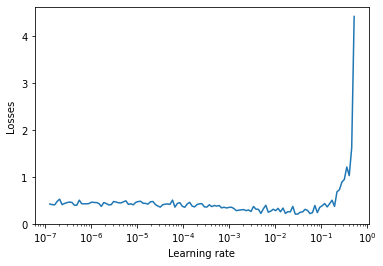

model reset done


In [756]:
lr_finder.plot()
model= lr_finder.reset()

## Save model

In [757]:
def createCheckpoint(filename=Path("./pocovid.pt")):
    checkpoint = {'epoch': 5,
                  'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,} 
    torch.save(checkpoint , filename)
createCheckpoint()

In [758]:
checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [767]:
image , label = next(iter(dataloader["val"]))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output)
output = output>0.2

In [768]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
    image = image.to("cpu").clone().detach()
    image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
    image = image.permute(1,2,0) 
    image = torch.clamp(image,0,1)
    return image.numpy()

def visualize(image , actual , pred):
    fig,ax = plt.subplots()
    ax.imshow(denormalize(image))
    ax.grid(False)
    classes =  np.array(classLabels)[np.array(actual,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16)#, weight='bold')
        
    classes =  np.array(classLabels)[np.array(pred,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(160 , i*20  , s , verticalalignment='top', color="red", fontsize=16)#, weight='bold')
    plt.show()

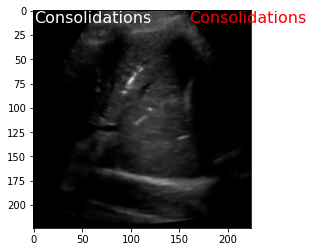

In [779]:
visualize(image[2] , label[2].tolist() , output[2].tolist())

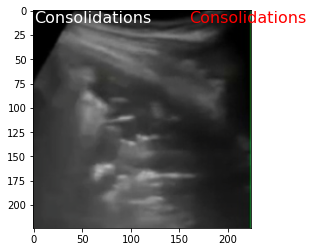

In [795]:
visualize(image[15] , label[15].tolist() , output[15].tolist())


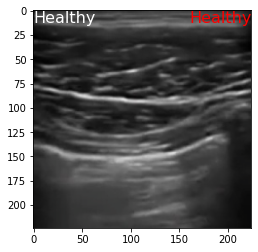

In [771]:
visualize(image[29] , label[29].tolist() , output[29].tolist())



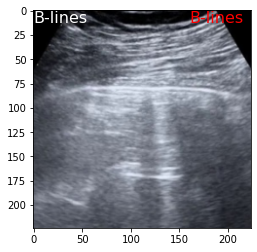

In [776]:
visualize(image[16] , label[16].tolist() , output[16].tolist())
